In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import scipy
from scipy.stats import cosine
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = cosine.rvs(size=5000)
p_x = torch.distributions.von_mises.VonMises(math.pi/2, 0.5)

#Training parameters
N_EPOCHS = 100
N_SAMPLES = 5000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
#x_samples = cosine.rvs(size=5000)
#x_sample = torch.as_tensor(x_samples)[:,None]


In [4]:
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

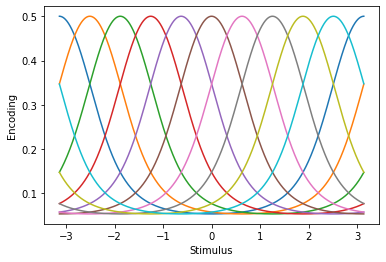

In [5]:
#CIRCULAR ENCODER
enc_circ = CircularBernoulliEncoder(N)
dec = MLPDecoder_circ(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [6]:
#Modified Bessel function (to compute distortion)

class ModifiedBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, k, nu):
        ctx._nu = nu
        ctx.save_for_backward(k)
        return torch.from_numpy(scipy.special.iv(nu, k.detach().numpy()))
    @staticmethod
    def backward(ctx, grad_out):
        k, = ctx.saved_tensors
        nu = ctx._nu
        
        return 0.5* grad_out *(ModifiedBessel.apply(k, nu - 1.0)+ModifiedBessel.apply(k, nu + 1.0)), None

modified_bessel = ModifiedBessel.apply


#Circular distortion

def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,log_k = decoder(r)
    #log_k =2.29*torch.ones(1)
    #k = 1/sigma2_dec
    logq_x_r = torch.exp(log_k)*torch.cos(x-mu_dec) - torch.log(modified_bessel(torch.exp(log_k),0)) - torch.log(2*torch.as_tensor(math.pi))
    D = -logq_x_r.mean()
    return D

In [7]:
q = rate_ising(N)
rate = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [8]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters(), enc_circ.parameters(), q.parameters())
lr = 1e-4
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(10000):
    rate = q(enc_circ,x_fine)
    dist = distortion_circular(x_fine,enc_circ,dec)
    loss = dist + rate
    #print(enc_circ.log_ks)
    opt.zero_grad()
    loss.backward()
    opt.step()
    lossVec.append(loss.item())
    rateVec.append(rate.item())
    distVec.append(dist.item())

Text(0, 0.5, 'Encoding')

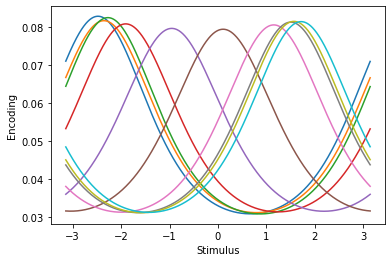

In [9]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")
#plt.xlim(-math.pi, math.pi)

Text(0, 0.5, 'Distortion')

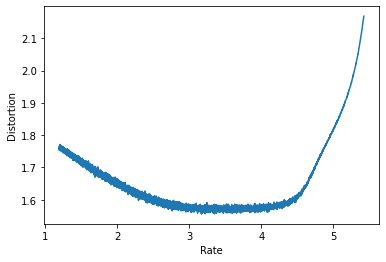

In [10]:
plt.plot(rateVec, distVec)
plt.xlabel("Rate")
plt.ylabel("Distortion")

c:\Users\auror\New_VAES\VAEs\src\encoders_decoders.py:271: UserWarning: Output 0 of SqueezeBackward0 is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  ..\torch\csrc\autograd\variable.cpp:547.)
  log_k_dec[log_k_dec<0] = torch.sqrt(log_k_dec[log_k_dec<0]**2)


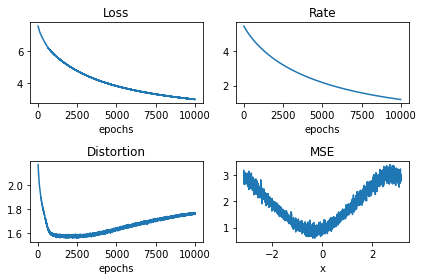

In [11]:
r = enc_circ.sample(x_sorted,50)
x_dec = dec.sample(r,50)
mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()


In [12]:
x_dec.shape
x_sorted.shape
a = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))
b = 2 - 2*torch.cos((x_dec - x_sorted[None,:]).mean(dim=(0,2)))
a.shape
b.shape


torch.Size([5000])

In [13]:
r= enc_circ.sample(x_fine,50)
mu_dec,log_k_dec = dec(r)
x_ext = dec.sample(r,50)
log_k_dec
x_ext


c:\Users\auror\New_VAES\VAEs\src\encoders_decoders.py:271: UserWarning: Output 0 of SqueezeBackward0 is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  ..\torch\csrc\autograd\variable.cpp:547.)
  log_k_dec[log_k_dec<0] = torch.sqrt(log_k_dec[log_k_dec<0]**2)


tensor([[[ 0.2641, -0.7507, -0.5294,  ..., -0.3155,  0.7093,  1.5445],
         [-2.5652, -0.0952, -0.0053,  ...,  0.2167,  0.1441, -0.9511],
         [-0.5009, -0.4011, -0.4159,  ..., -0.9038, -1.2487, -1.5386],
         ...,
         [ 2.7099, -1.3537,  2.7394,  ...,  0.9400, -1.9914, -1.7725],
         [-1.8333,  0.1140,  0.2678,  ..., -0.2955,  0.3052, -0.4780],
         [-0.5498,  0.2361, -0.4836,  ..., -1.7040, -0.7358, -1.6569]],

        [[ 0.4055,  0.6333,  0.0814,  ..., -0.5899,  0.2552, -1.4131],
         [-1.7875, -0.0147,  0.0134,  ..., -1.7619, -0.9115, -0.9457],
         [-0.9029, -0.0256, -1.0290,  ..., -0.9062,  2.1686, -2.5995],
         ...,
         [ 2.7257,  0.1305,  3.1049,  ..., -0.0270, -1.5362, -1.5804],
         [-1.7689, -0.0599, -0.5663,  ..., -1.5689,  1.5277,  0.9200],
         [-0.6637, -0.1671,  0.1154,  ..., -1.7573,  0.0237,  1.1158]],

        [[-0.5864, -0.5374, -0.1996,  ..., -0.2495, -0.8606, -2.0435],
         [-2.6684, -0.9694,  0.1076,  ..., -0

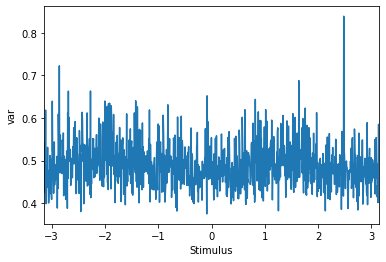

In [14]:
#variance of the decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,torch.exp(log_k_dec).mean(dim=1).detach())
    plt.ylabel("var")
    plt.xlabel("Stimulus")
    plt.xlim(-math.pi,math.pi)

(-3.141592653589793, 3.141592653589793)

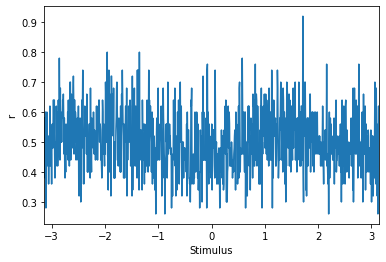

In [15]:
#Probability of each neuron to be active. The x axis is the stimulus space
plt.plot(x_fine,r.sum(dim=2).mean(dim=1))
plt.ylabel("r")
plt.xlabel("Stimulus")
plt.xlim(-math.pi,math.pi)

c:\Users\auror\New_VAES\VAEs\src\encoders_decoders.py:271: UserWarning: Output 0 of SqueezeBackward0 is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  ..\torch\csrc\autograd\variable.cpp:547.)
  log_k_dec[log_k_dec<0] = torch.sqrt(log_k_dec[log_k_dec<0]**2)


(-3.141592653589793, 3.141592653589793)

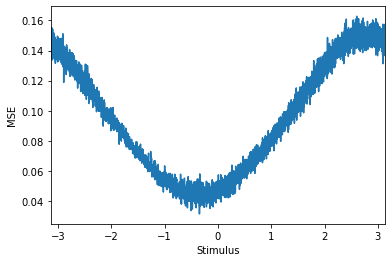

In [16]:
#Mean squared error

r = enc_circ.sample(x_sorted,100)
x_dec = dec.sample(r,100)


mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))
plt.plot(x_sorted,mseVec.detach()/20)
plt.ylabel("MSE")
plt.xlabel("Stimulus")
plt.xlim(-math.pi,math.pi)


In [17]:
x_ext.shape

torch.Size([50, 1000, 50])

In [18]:
l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,15,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.1)
mu_dec,log_k = dec(r)
log_k =2.29*torch.ones(1)
logq_x_r = torch.exp(log_k)*torch.cos(x_fine-mu_dec[0,:]) - torch.log(modified_bessel(torch.exp(log_k),0)) - torch.log(2*torch.as_tensor(math.pi))

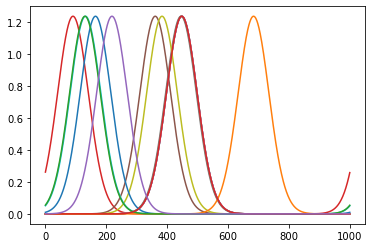

In [19]:
plt.plot(torch.exp(logq_x_r.detach()))

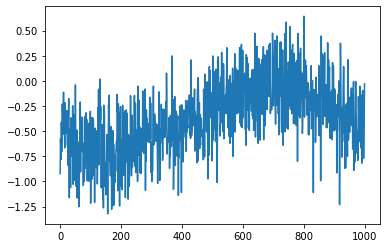

In [20]:
plt.plot(mu_dec.mean(dim=1).detach())

In [21]:
log_k[0,0]

IndexError: too many indices for tensor of dimension 1